    area  price    street        ward    district
0   82.0   2.70  Vĩnh Lộc  Vĩnh Lộc B  Bình Chánh
1  104.0   0.83  Vĩnh Lộc  Vĩnh Lộc B  Bình Chánh
2   52.0   0.41  Vĩnh Lộc  Vĩnh Lộc B  Bình Chánh
5   56.0   0.41  Vĩnh Lộc  Vĩnh Lộc B  Bình Chánh
7  115.0   3.20  Vĩnh Lộc  Vĩnh Lộc B  Bình Chánh
Data length: 28

Model coefficient:  [[0.0069931]]
Model intercept  [2.36309863]


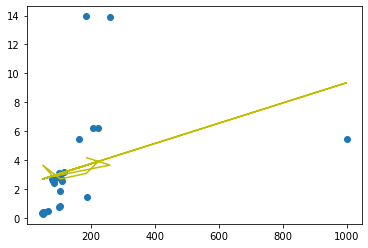

Root Mean Square Error:  1.8916148577846295


ValueError: Found input variables with inconsistent numbers of samples: [25, 28]

In [27]:
from numpy.lib import polynomial
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def getData(post_type, street, ward, district):
    
    conn = psycopg2.connect(database="real_estate_data", user="postgres", password="361975Warcraft")
    # cur = conn.cursor()
    query = """
        SELECT area, price, street, ward, district
        FROM bds_realestatedata 
        WHERE
            post_type = '{}' AND
            area IS NOT NULL AND
            price IS NOT NULL AND
            street = '{}' AND
            ward = '{}' AND
            district = '{}';
    """.format(post_type, street, ward, district)
    
    # cur.execute(query)
    # data = cur.fetchall()
    data = pd.read_sql_query(query, con=conn)

    return prepareData(data)
#     return data

def prepareData(data):

    data.drop_duplicates(subset='area', keep='first', inplace=True)

    # use percentiles to remove outliers:
    area_upper_bound = data['area'].quantile(0.95)
    area_lower_bound = data['area'].quantile(0.05)
    price_upper_bound = data['price'].quantile(0.95)
    price_lower_bound = data['price'].quantile(0.05)

    data = data[
        (data['area'] < area_upper_bound) &
        (data['area'] > area_lower_bound) &
        (data['price'] < price_upper_bound) &
        (data['price'] > price_lower_bound)
    ]
    
    print(data.head())
    print("Data length: {}\n".format(len(data)))

    # Use log transformation to scale data:

#     log_transform_area = (data['area']+1).transform(np.log)
#     log_transform_price = (data['price']+1).transform(np.log)
#     log_transform_data = pd.DataFrame({'area': log_transform_area, 'price': log_transform_price, 'street': data['street'], 'ward': data['ward'], 'district': data['district']})

#     print("--------------------------------------------------------")
#     print(log_transform_data.head())
#     print("--------------------------------------------------------")
#     print("Log Transformation Data length: ", len(log_transform_data))

#     return log_transform_data
    return data

def convertData(data):
    # Selection few attributes
    attributes = ['area',]
    predict_val = ['price']
    
    # Vector attributes of lands
    X = data[attributes]
    # Vector price of land
    Y = data[predict_val]
    
    # Convert into arr:
    X = np.array(X)
    Y = np.array(Y)
    
    # Split data to training test and testing test
    # training data : testing data = 80 : 20
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
#     return X_train, X_test, Y_train, Y_test
    return X, Y

# Linear Regression Model:
def linearRegressionModel(X, Y):
    model = linear_model.LinearRegression()

    # Training process
    model.fit(X, Y)
    
    # return model coefficient, intercept:
    return model

# Polynomial Regression:
def polynomialRegression(X, Y, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X_train)
#     X_test_poly = polynomial_features.fit_transform(X_test)

    # calc linear regression again:
    poly_model = linearRegressionModel(X_poly, Y)
    return poly_model, X_poly

# Data:
post_type = 'Bán đất'
street = 'Vĩnh Lộc'
ward = 'Vĩnh Lộc B'
district = 'Bình Chánh'

data = getData(post_type, street, ward, district)
X, Y = convertData(data)

model = linearRegressionModel(X, Y)
model_coef = model.coef_
model_intercept = model.intercept_
Y_train_pred = model.predict(X)

""" 
y = ax1 + b
[a] is coefficient
b is intercept
"""

print("Model coefficient: ", model_coef)
print("Model intercept ", model_intercept)
# print("Model: y = {coef}x + {intercept}".format(coef=model_coef[0], intercept=model_intercept))

# Plot model:
plt.scatter(X, Y)
# plt.plot(X, model_coef*X + model_intercept, color='y')
plt.plot(X, Y_pred, color='y')
plt.show()

# Find root mean square error of model between Y_predict and Y
linear_rmse = np.sqrt(mean_squared_error(Y, Y_pred))
print("Root Mean Square Error: ", rmse)

def degree_test(degree):
    # Call polynomial regression
    poly_model, X_poly = polynomialRegression(X, Y, degree)
    poly_model_coef = poly_model.coef_
    poly_model_intercept = poly_model.intercept_
    Y_poly_pred = poly_model.predict(X_poly)

    print("\n\nAfter using polynomial regression with degree = {}: ".format(degree))

    print("Model coefficient: ", poly_model_coef)
    print("Model intercept: ", poly_model_intercept)
    # print("Model: y = {} + {}x + {}x^2 + {}".format(model_coef[0], model_coef[1], model_coef[2], model_intercept))

    # Plot model:
    plt.scatter(X, Y)
    # plt.plot(X, model_coef[0] + model_coef[1]*X + model_coef[2]*pow(X, 2) + model_intercept, color='g')
    plt.plot(X, Y_poly_pred, color='g')
    plt.show()

    # Find root mean square error of model between Y_predict and Y
    rmse = np.sqrt(mean_squared_error(Y, Y_poly_pred))
    print("Root Mean Square Error: ", rmse)

    return rmse

min_rmse = linear_rmse
degree = 1
for i in range(2, 8):
    rmse = degree_test(i)
    if rmse < min_rmse:
        min_rmse = rmse
        degree = i
print("Min rmse: {} with model with degree: {}".format(min_rmse, degree))